In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Project Objective

The objective of this project is to develop an end-to-end machine learning pipeline that predicts home sale prices on the Ames dataset. I will perform exploratory data analysis, data cleaning and feature engineering, model training, and evaluation to identify the most influential factors and deliver accurate price predictions.


# 1. Exploratory Data Analysis (EDA)


Train Data Shape: (1460, 81)
Test Data Shape:  (1459, 80)
Missing Values (Top 20):
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


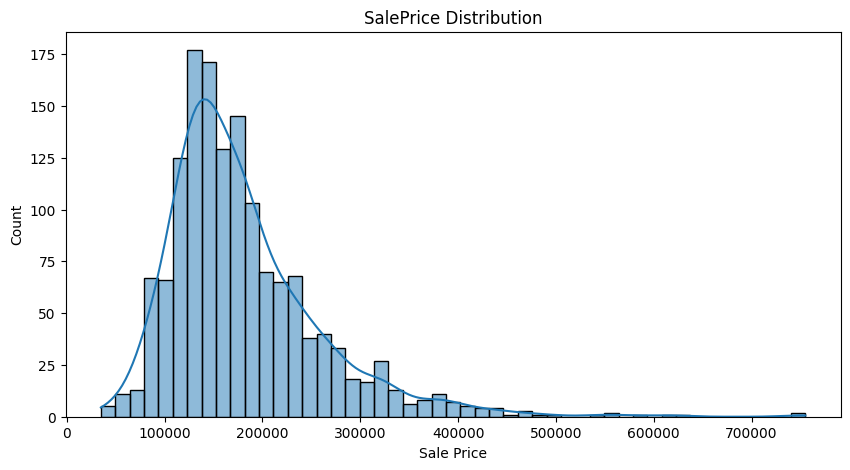

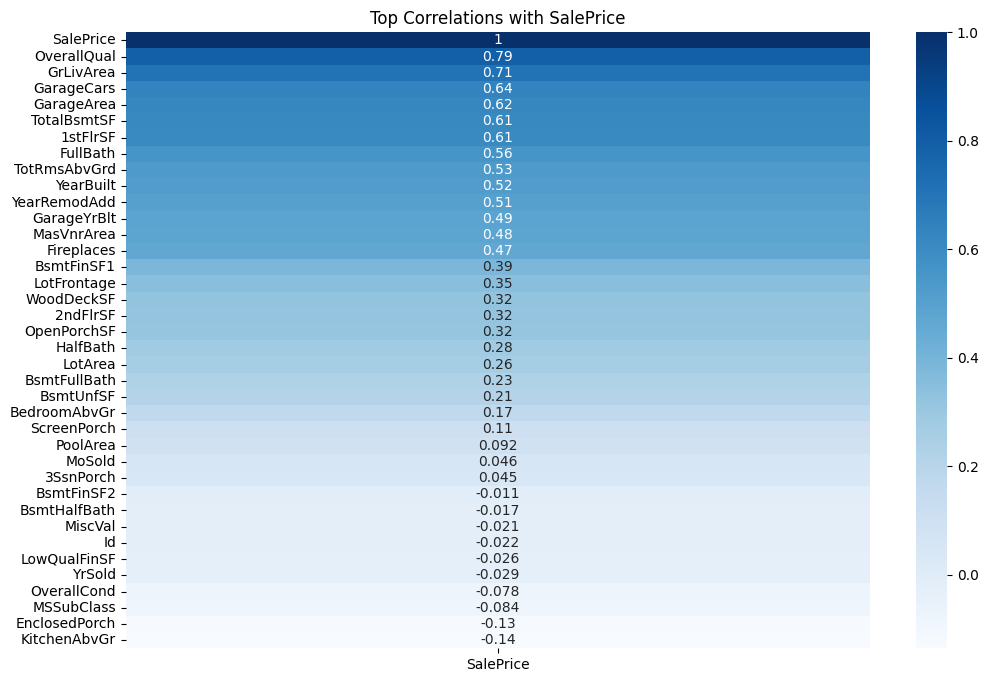

In [4]:
# 1. Load data
import pandas as pd
train = pd.read_csv("/kaggle/input/home-data-for-ml-course/train.csv")
test  = pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv")

# 2. Basic dataset overview
print("Train Data Shape:", train.shape)
print("Test Data Shape: ", test.shape)

# 3. Missing values (top 20)
missing = train.isnull().sum().sort_values(ascending=False).head(20)
print("Missing Values (Top 20):\n", missing)

# 4. Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# 4a. SalePrice distribution
plt.figure(figsize=(10, 5))
sns.histplot(train['SalePrice'], kde=True)
plt.title("SalePrice Distribution")
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.show()

# 4b. Correlation heatmap (numeric only)
plt.figure(figsize=(12, 8))
corr = train.corr(numeric_only=True)[['SalePrice']].sort_values(by='SalePrice', ascending=False)
sns.heatmap(corr, annot=True, cmap='Blues')
plt.title("Top Correlations with SalePrice")
plt.show()


### 1. Exploratory Data Analysis (EDA)

In this section, I have loaded both the training and test datasets and inspected their dimensions. I have identified the top missing-value columns to inform our imputation strategy. I have examined the distribution of **SalePrice** and observed a pronounced right skew, indicating that a log transform may be beneficial. I have computed the strongest numeric correlations with **SalePrice** and found that features like **OverallQual**, **GrLivArea**, **GarageCars**, **GarageArea**, and **TotalBsmtSF** exhibit the highest correlations—these factors should be prioritized in our model.


# 2. Data Preprocessing


In [6]:
# Import core libraries
import pandas as pd
import numpy as np

# ======================================================================
# 1. Data Loading & Initial Setup
# ======================================================================

# Load raw data from Kaggle input files
train = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')

# Preserve original IDs for final submission
test_ids = test['Id'].copy()

# Store target variable separately before combining datasets
train_labels = train['SalePrice'].copy()

# ======================================================================
# 2. Combine Train & Test Data
# ======================================================================

# Concatenate while dropping SalePrice from train to prevent target leakage
# ignore_index=True ensures clean index for future splits
all_data = pd.concat([train.drop('SalePrice', axis=1), test], ignore_index=True)

# ======================================================================
# 3. Missing Value Treatment (3 Categories)
# ======================================================================

# 3A) Features where "None" indicates absence of feature
none_cols = [
    'Alley',        # No alley access
    'PoolQC',       # No pool
    'Fence',        # No fence
    'MiscFeature',  # No miscellaneous feature
    'FireplaceQu',  # No fireplace
    'GarageType',   # No garage (and related garage features)
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'BsmtQual',     # No basement (and related basement features)
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'MasVnrType'    # No masonry veneer
]
all_data[none_cols] = all_data[none_cols].fillna('None')

# 3B) Numeric features where missing implies 0 value
zero_cols = [
    'GarageYrBlt',  # No garage = year built irrelevant
    'GarageArea',   # No garage = 0 area
    'GarageCars',   # No garage = 0 car capacity
    'BsmtFinSF1',   # No basement = 0 finished sqft
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',  # Total basement area
    'BsmtFullBath', # No basement = 0 bathrooms
    'BsmtHalfBath',
    'MasVnrArea'    # No masonry = 0 area
]
all_data[zero_cols] = all_data[zero_cols].fillna(0)

# 3C) Special cases requiring custom imputation
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))  # Lot frontage depends on neighborhood
all_data['Electrical'] = all_data['Electrical'].fillna('SBrkr')  # Most common value
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])  # Use mode

# ======================================================================
# 4. Feature Engineering
# ======================================================================

# Create composite features that capture important relationships:

# Total living area (above + below grade)
all_data['TotalSF'] = (all_data['TotalBsmtSF'] 
                       + all_data['1stFlrSF'] 
                       + all_data['2ndFlrSF'])

# Age-related features
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['YearsSinceRemodel'] = all_data['YrSold'] - all_data['YearRemodAdd']

# Bathroom score (weighted sum)
all_data['TotalBath'] = (all_data['FullBath'] 
                         + 0.5 * all_data['HalfBath'] 
                         + all_data['BsmtFullBath'] 
                         + 0.5 * all_data['BsmtHalfBath'])

# Binary flags for feature presence
for feat in ['PoolArea', '2ndFlrSF', 'GarageArea', 'TotalBsmtSF', 'Fireplaces']:
    all_data[f'Has{feat}'] = (all_data[feat] > 0).astype(int)

# Convert MSSubClass to string (it's categorical despite numeric values)
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

# ======================================================================
# 5. Categorical Encoding
# ======================================================================

# 5A) Ordinal Encoding for features with inherent rankings
ordinal_maps = {
    # Quality ratings (None=0, Poor=1 -> Excellent=5)
    'ExterQual': {'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    'ExterCond': {'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    'BsmtQual': {'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    'BsmtCond': {'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    'HeatingQC': {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    'KitchenQual': {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    'FireplaceQu': {'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    'GarageQual': {'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    'GarageCond': {'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    'PoolQC': {'None':0,'Fa':1,'TA':2,'Gd':3,'Ex':4},
    
    # Special ordinal features
    'BsmtExposure': {'None':0,'No':1,'Mn':2,'Av':3,'Gd':4},
    'BsmtFinType1': {'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6},
    'BsmtFinType2': {'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6},
}

for col, mapping in ordinal_maps.items():
    all_data[col] = all_data[col].map(mapping).fillna(0).astype(int)

# 5B) Binary Encoding for simple yes/no features
all_data['CentralAir'] = (all_data['CentralAir'] == 'Y').astype(int)
all_data['PavedDrive'] = all_data['PavedDrive'].map({'N':0,'P':1,'Y':2}).astype(int)

# 5C) Manual ordinal encoding for land features
all_data['LandSlope'] = all_data['LandSlope'].map({'Gtl':2,'Mod':1,'Sev':0})
all_data['LandContour'] = all_data['LandContour'].map({'Lvl':3,'Bnk':2,'HLS':1,'Low':0})
all_data['LotShape'] = all_data['LotShape'].map({'Reg':4,'IR1':3,'IR2':2,'IR3':1})

# 5D) Simple binary road encoding
all_data['Street'] = all_data['Street'].map({'Grvl':0,'Pave':1})

# 5E) One-Hot Encoding for remaining categoricals
cat_cols = all_data.select_dtypes(include=['object']).columns
all_data = pd.get_dummies(all_data, columns=cat_cols, drop_first=True)

# ======================================================================
# 6. Final Cleanup
# ======================================================================

# Drop ID column (no predictive value)
all_data.drop(['Id'], axis=1, inplace=True)

# Split back into train and test sets
n_train = train.shape[0]
train_processed = all_data.iloc[:n_train].copy()
test_processed = all_data.iloc[n_train:].copy()

# Restore target variable to training set
train_processed['SalePrice'] = train_labels

# ======================================================================
# 7. Target Variable Processing
# ======================================================================

# Remove extreme outliers (only in training data)
train_processed = train_processed[train_processed['GrLivArea'] < 4500]

# Log-transform SalePrice to normalize distribution
train_processed['SalePrice'] = np.log1p(train_processed['SalePrice'])

# ======================================================================
# 8. Validation & Output
# ======================================================================

print("Processed training set shape:", train_processed.shape)
print("Processed test set shape:", test_processed.shape)

# Verify no missing values remain
assert not all_data.isnull().any().any(), "Missing values detected!"

# Save processed data
train_processed.to_csv('train_processed.csv', index=False)
test_processed.to_csv('test_processed.csv', index=False)

Processed training set shape: (1458, 234)
Processed test set shape: (1459, 233)


---
## 2. Data Preprocessing

In this section, I have:

1. **Loaded** both the training and test datasets and preserved `Id` and `SalePrice` for later.
2. **Imputed** missing values:
   - Filled truly absent categories (e.g. `Alley`, `PoolQC`, `FireplaceQu`, `Bsmt…`, `MasVnrType`) with “None.”
   - Replaced numeric gaps (e.g. `GarageYrBlt`, `BsmtFinSF1`, `MasVnrArea`) with 0 or median values.
   - Applied group‐median imputation for `LotFrontage` by neighborhood and filled `Electrical` with the most frequent value.
3. **Engineered** new features:
   - `TotalSF` = total above‐ and below‐grade square footage.
   - `HouseAge` and `YearsSinceRemodel` by subtracting build/remodel years from `YrSold`.
   - `TotalBath` combining full and half baths.
   - Binary flags (e.g. `HasPool`, `HasGarage`, `HasBsmt`, `HasFireplace`, `Has2ndFloor`).
4. **Encoded** categorical and ordinal variables:
   - Converted story type (`MSSubClass`) and binary roads (`Street`) to numeric.
   - Applied explicit ordinal mappings for quality/condition features (`ExterQual`, `BsmtQual`, etc.) and driveway slope (`PavedDrive`).
   - Mapped property shape (`LotShape`), contour, and slope to ordered integers.
   - One-hot–encoded all remaining categorical columns.
5. **Aligned** the processed train and test feature sets to ensure identical columns.
6. **Log-transformed** the target `SalePrice` to stabilize variance and improve modeling.
---


# 3. Modeling


# 4. Evaluation


# 5. Conclusion
